In [1]:
import config
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import json
from urllib.request import urlopen
import ast
import datetime
import os
import altair as alt
import math
import time
from IPython.display import Image, display
import seaborn as sns
import networkx as nx
from collections import Counter
pd.set_option('display.max_colwidth', None)
pd.options.mode.copy_on_write = True

In [2]:
API_KEY = config.api_key
current_directory = os.getcwd()
main_dir = os.path.dirname(current_directory)
data = os.path.join(os.path.dirname(current_directory), "data")
images = os.path.join(os.path.dirname(current_directory), "images")
htmls = os.path.join(os.path.dirname(current_directory), "htmls")
screenshots = os.path.join(os.path.dirname(current_directory), "screenshots")

### Now we need to find all bills during the time studied as well their respective sponsors and co-sponsors

1) We will find the (i) sponsored legislation and (ii) co-sponsored legislation of each member in the super-senate

2) We will keep bills introduced only during the time span studied: 2011-2021 (112th-116th congress)

In [3]:
super_senate = pd.read_csv(data + "//super_senate.csv")
super_senate.head(3)

,bioguideId,name,terms,state,party,birthYear,sponsoredLegislation_count,sponsoredLegislation_url,cosponsoredLegislation_count,cosponsoredLegislation_url,years_house,years_senate
0,C001098,"Cruz, Ted","{'item': [{'chamber': 'Senate', 'startYear': 2013}]}",Texas,Republican,1970,773.0,https://api.congress.gov/v3/member/C001098/sponsored-legislation,1579,https://api.congress.gov/v3/member/C001098/cosponsored-legislation,0,11
1,W000817,"Warren, Elizabeth","{'item': [{'chamber': 'Senate', 'startYear': 2013}]}",Massachusetts,Democratic,1949,569.0,https://api.congress.gov/v3/member/W000817/sponsored-legislation,3457,https://api.congress.gov/v3/member/W000817/cosponsored-legislation,0,11
2,W000802,"Whitehouse, Sheldon","{'item': [{'chamber': 'Senate', 'startYear': 2007}]}",Rhode Island,Democratic,1955,564.0,https://api.congress.gov/v3/member/W000802/sponsored-legislation,4062,https://api.congress.gov/v3/member/W000802/cosponsored-legislation,0,17


### To make life easier let's download our data from the congress.gov website with the appropriate filters:

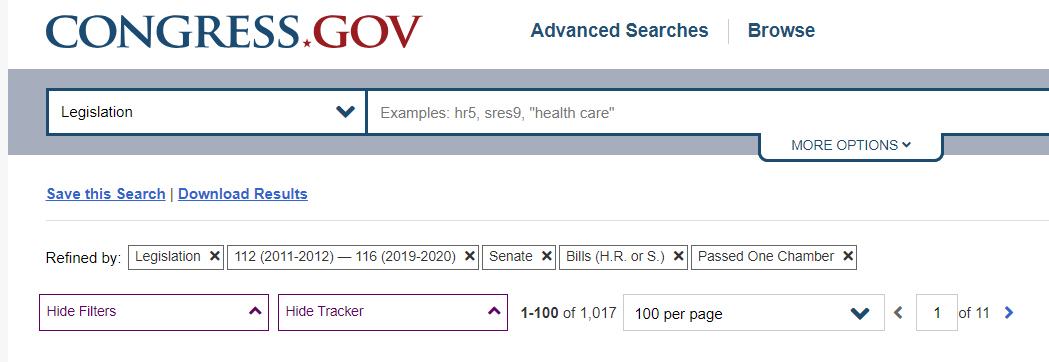

In [4]:
# Replace the file path with the correct one if needed
file_path = screenshots + '//Screenshot_1.png'
# Display the image
display(Image(filename=file_path))
#link
#https://www.congress.gov/search?q=%7B%22source%22%3A%22legislation%22%2C%22congress%22%3A%5B116%2C115%2C114%2C113%2C112%5D%2C%22chamber%22%3A%22Senate%22%2C%22type%22%3A%22bills%22%2C%22bill-status%22%3A%22passed-one%22%7D

- **We save the file in the data directory as bills.csv after deleting the first 3 rows (date of download,empty row, etc.)**


- **Unfortunately, bioguideId is not available.**

In [5]:
bills = pd.read_csv(data + "//bills.csv")
bills['Number of Cosponsors'] = bills['Number of Cosponsors'].fillna(0)
bills['Number of Cosponsors'] = bills['Number of Cosponsors'].apply(int)
bills.rename(columns={'Cosponsor': 'Cosponsor.0'}, inplace=True)
bills.head(5)

,Legislation Number,URL,Congress,Sponsor,Number of Cosponsors,Cosponsor.0,Cosponsor.1,Cosponsor.2,Cosponsor.3,Cosponsor.4,...,Cosponsor.89,Cosponsor.90,Cosponsor.91,Cosponsor.92,Cosponsor.93,Cosponsor.94,Cosponsor.95,Cosponsor.96,Cosponsor.97,Cosponsor.98
0,S. 5086,https://www.congress.gov/bill/116th-congress/senate-bill/5086,116th Congress (2019-2020),"Klobuchar, Amy [Sen.-D-MN]",0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,S. 5076,https://www.congress.gov/bill/116th-congress/senate-bill/5076,116th Congress (2019-2020),"Blunt, Roy [Sen.-R-MO]",0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,S. 5036,https://www.congress.gov/bill/116th-congress/senate-bill/5036,116th Congress (2019-2020),"Graham, Lindsey [Sen.-R-SC]",0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,S. 4996,https://www.congress.gov/bill/116th-congress/senate-bill/4996,116th Congress (2019-2020),"Graham, Lindsey [Sen.-R-SC]",5,"Coons, Christopher A. [Sen.-D-DE]","Rubio, Marco [Sen.-R-FL]","Cardin, Benjamin L. [Sen.-D-MD]","Blackburn, Marsha [Sen.-R-TN]","Carper, Thomas R. [Sen.-D-DE]",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,S. 4971,https://www.congress.gov/bill/116th-congress/senate-bill/4971,116th Congress (2019-2020),"Klobuchar, Amy [Sen.-D-MN]",3,"Hoeven, John [Sen.-R-ND]","Cramer, Kevin [Sen.-R-ND]","Smith, Tina [Sen.-D-MN]",NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
print("-------------------------Dataset stats-------------------------\n")
print(f"The median number of cosponsors is {bills['Number of Cosponsors'].median()} and the mean is \
{bills['Number of Cosponsors'].mean()}\n")
print(f"{len(bills.Sponsor.unique())} Senators out of 149 (see previous notebook) sponsored at least \
one bill that passed the Senate\n")
print(f"Average of {bills.shape[0]/149} passed bills per Senator\n")
print("-------------------------*************-------------------------")

-------------------------Dataset stats-------------------------

The median number of cosponsors is 3.0 and the mean is 9.139626352015732

137 Senators out of 149 (see previous notebook) sponsored at least one bill that passed the Senate

Average of 6.825503355704698 passed bills per Senator

-------------------------*************-------------------------


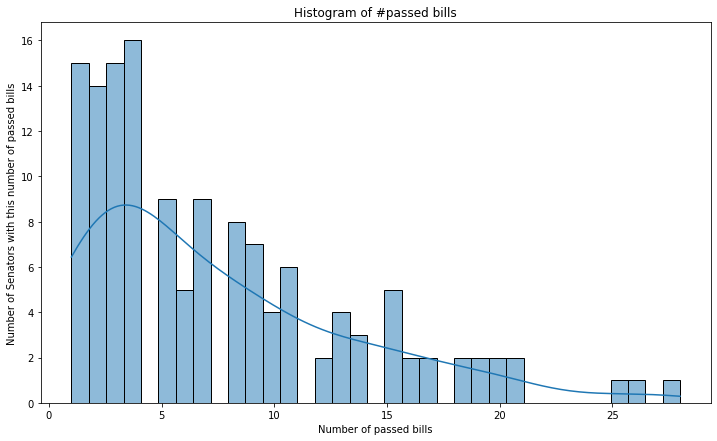

In [7]:
value_counts = bills.Sponsor.value_counts().sort_values(ascending=True)
fig, ax = plt.subplots(figsize=[12,7])
sns.histplot(value_counts.values, kde=True, bins=35, ax=ax)
ax.set_title("Histogram of #passed bills")
ax.set_xlabel("Number of passed bills")
ax.set_ylabel("Number of Senators with this number of passed bills") 
fig.savefig(images + "//passed_bills_hist.png",transparent=True,facecolor='w')

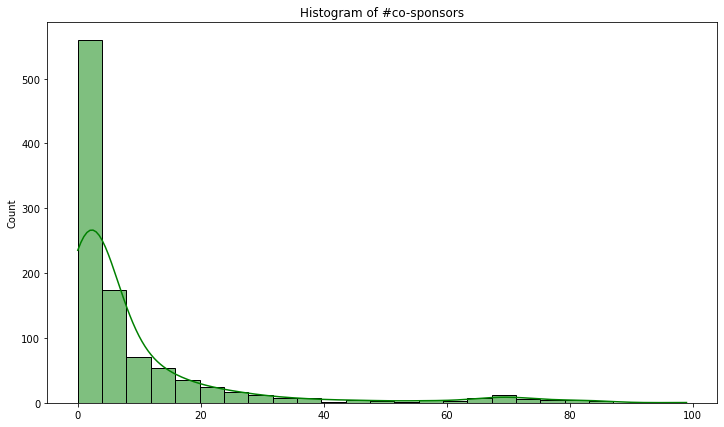

In [8]:
cosponsors = bills["Number of Cosponsors"].values
fig, ax = plt.subplots(figsize=[12,7])
sns.histplot(cosponsors, kde=True, bins=25, color='green', ax=ax)
ax.set_title("Histogram of #co-sponsors")
fig.savefig(images + "//cosponsors_hist.png",transparent=True,facecolor='w')

In [9]:
graph = dict()
for index, row in bills.iterrows():
    
    if row.Sponsor not in graph:
        graph[row.Sponsor] = dict()
    
    nco = row["Number of Cosponsors"]
    for i in range(nco): 
        if row[f"Cosponsor.{i}"] in graph[row.Sponsor]:
            graph[row.Sponsor][row[f"Cosponsor.{i}"]] += 1
        else:
            graph[row.Sponsor][row[f"Cosponsor.{i}"]] = 1        

In [10]:
#example
graph["Sanders, Bernard [Sen.-I-VT]"]

{'Rockefeller, John D., IV [Sen.-D-WV]': 1,
 'Murray, Patty [Sen.-D-WA]': 1,
 'Burr, Richard [Sen.-R-NC]': 1,
 'Isakson, Johnny [Sen.-R-GA]': 1,
 'Brown, Sherrod [Sen.-D-OH]': 1,
 'Tester, Jon [Sen.-D-MT]': 1,
 'Begich, Mark [Sen.-D-AK]': 1,
 'Johanns, Mike [Sen.-R-NE]': 1,
 'Blumenthal, Richard [Sen.-D-CT]': 1,
 'Boozman, John [Sen.-R-AR]': 1,
 'Moran, Jerry [Sen.-R-KS]': 1,
 'Heller, Dean [Sen.-R-NV]': 1,
 'Hirono, Mazie K. [Sen.-D-HI]': 1,
 'Markey, Edward J. [Sen.-D-MA]': 1,
 'Collins, Susan M. [Sen.-R-ME]': 1,
 'Landrieu, Mary L. [Sen.-D-LA]': 1,
 'Murkowski, Lisa [Sen.-R-AK]': 1,
 'Leahy, Patrick J. [Sen.-D-VT]': 1}

In [11]:
D=nx.DiGraph()
for i in graph:
    for j in graph[i]:
        D.add_edge(j, i, weight = graph[i][j])

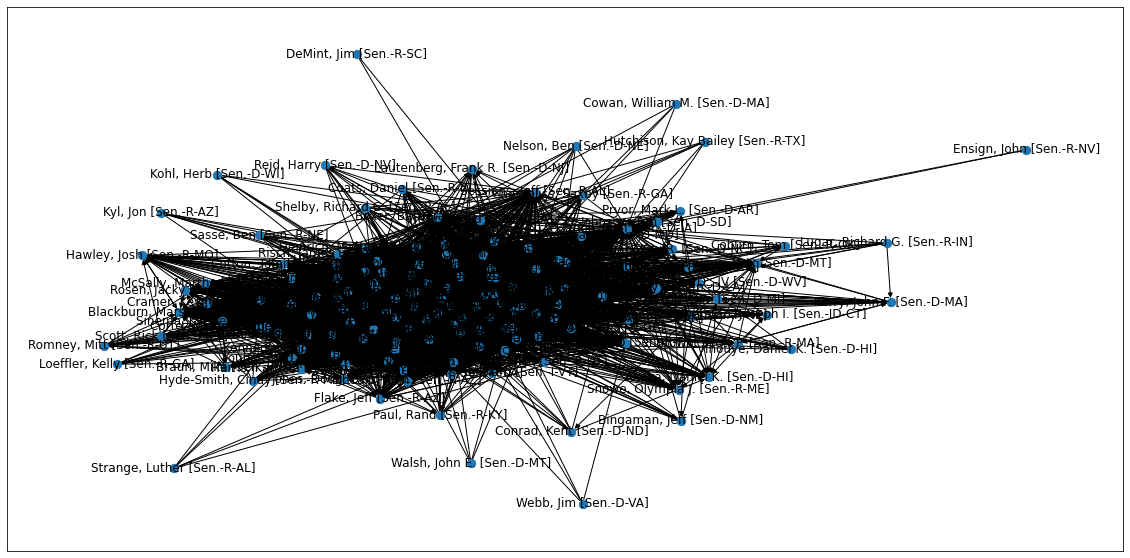

In [12]:
pos = nx.spring_layout(D)
plt.figure(3,figsize=(20,10)) 
nx.draw_networkx(D, node_size=70, pos=pos)
plt.show()

Not really a good visualization...

...we will come back later.

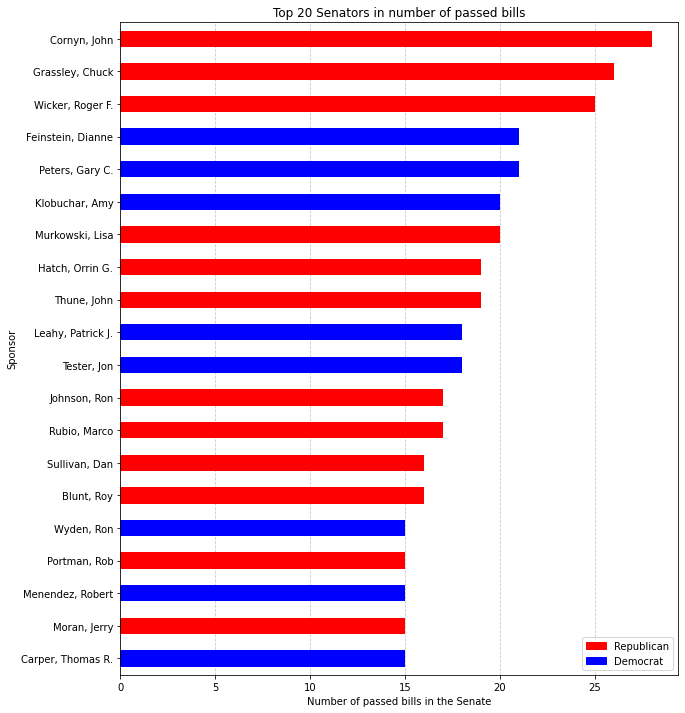

In [13]:
value_counts_filtered = value_counts[-20:]
color_map = ['red' if '[Sen.-R-' in sponsor else 'blue' for sponsor in value_counts_filtered.index]
#cut party from name
new_data = {name.split('[')[0].strip(): count for name, count in value_counts_filtered.items()}
new_data = pd.Series(new_data)
plt.figure(figsize=(10, 12))
ax = new_data.plot(kind='barh', color=color_map)
plt.xlabel('Number of passed bills in the Senate')
plt.ylabel('Sponsor')
plt.title('Top 20 Senators in number of passed bills')
plt.grid(axis='x', linestyle='--', alpha=0.7)  # Adding grid to the x-axis
ax.set_axisbelow(True)  # Display the grid behind the bars
legend_labels = ['Republican', 'Democrat']
legend_handles = [plt.Rectangle((0, 0), 1, 1, color='red'), plt.Rectangle((0, 0), 1, 1, color='blue')]
plt.legend(legend_handles, legend_labels, loc='lower right')
plt.savefig(images + "//passed_bills.png",transparent=True,facecolor='w', dpi=300)

In [14]:
pagerank = nx.pagerank(D)
sorted_dict = {k: v for k, v in sorted(pagerank.items(), key=lambda item: item[1], reverse=True)}

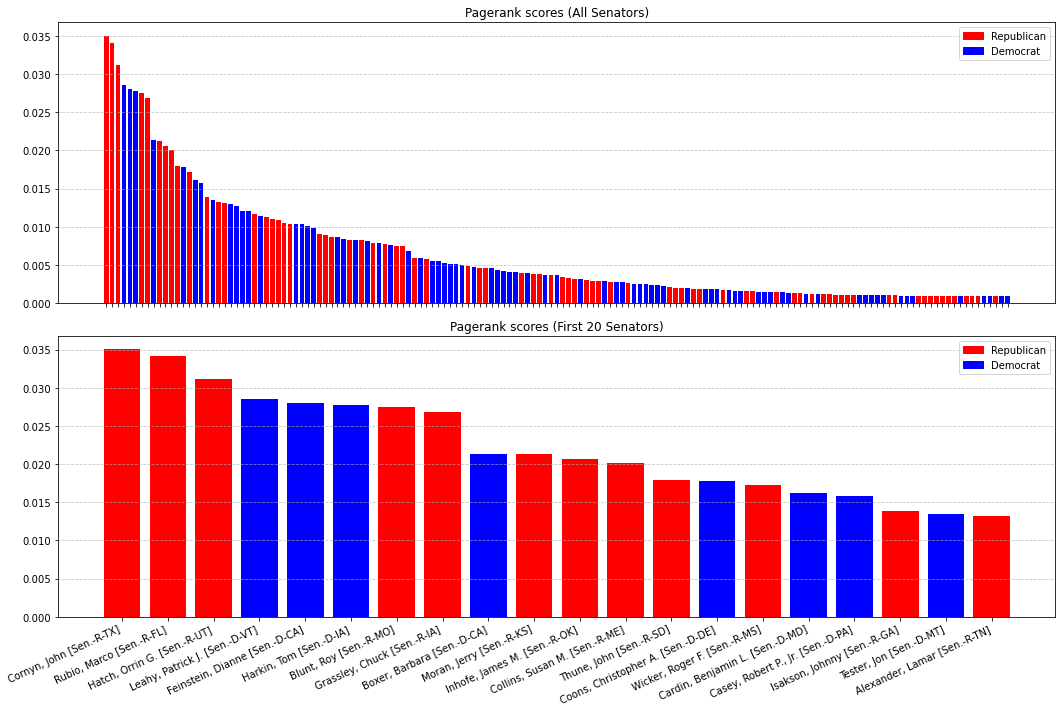

In [15]:
color_map = ['red' if '[Sen.-R-' in sponsor else 'blue' for sponsor in sorted_dict]
# Create a figure with two subplots
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(15, 10))
legend_labels = ['Republican', 'Democrat']
legend_handles = [plt.Rectangle((0, 0), 1, 1, color='red'), plt.Rectangle((0, 0), 1, 1, color='blue')]
new_dict = {name.split('[')[0].strip(): count for name, count in sorted_dict.items()}
# Plot the first subplot (all values in the dictionary)
axes[0].bar(new_dict.keys(), new_dict.values(), color=color_map)
axes[0].set_title('Pagerank scores (All Senators)')
axes[0].grid(axis='y', linestyle='--', alpha=0.7)  # Adding grid to the y-axis
axes[0].set_xticklabels([])  # Hide x-axis tick labels for better layout
axes[0].legend(legend_handles, legend_labels, loc='upper right')
# Plot the second subplot (first 20 values in the dictionary)
first_20_keys = list(sorted_dict.keys())[:20]
first_20_values = [sorted_dict[key] for key in first_20_keys]
color_map_first_20 = [color_map[i] for i in range(20)]
axes[1].bar(first_20_keys, first_20_values, color=color_map_first_20)
axes[1].set_title('Pagerank scores (First 20 Senators)')
axes[1].grid(axis='y', linestyle='--', alpha=0.7)  # Adding grid to the y-axis
axes[1].set_xticks(range(len(first_20_keys)))
axes[1].set_xticklabels(first_20_keys, rotation=25, ha='right')
axes[1].legend(legend_handles, legend_labels, loc='upper right')
plt.tight_layout()
plt.savefig(images + "//pagerank.png", transparent=True, facecolor='w', dpi=300)

**As we can see gross output is somewhat different than the significance Pagerank assigns to nodes (Senators). Let's try to visualize this.**

In [16]:
pagerank = {name: index+1 for index, name in enumerate(first_20_keys)}
gross = value_counts_filtered.iloc[::-1]
gross = {name: index+1 for index, name in enumerate(gross.keys())}
compare = set(gross.keys()) | set(pagerank.keys())
diff = dict()
for i in compare:
    if i in pagerank:
        if i in gross:
            diff[i] = - (pagerank[i] - gross[i])
        else:
            diff[i] = 21 - pagerank[i]
    else:
        diff[i] = - (21 - gross[i])

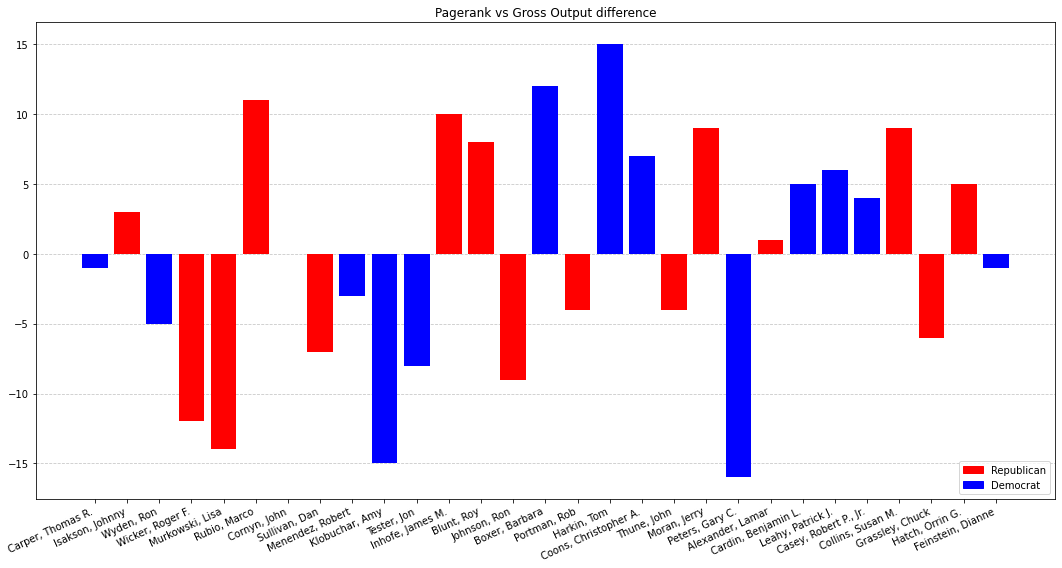

In [17]:
color_map = ['red' if '[Sen.-R-' in sponsor else 'blue' for sponsor in diff.keys()]
# Create a single plot
plt.figure(figsize=(15, 8))
diff = {name.split('[')[0].strip(): count for name, count in diff.items()}
plt.bar(diff.keys(), diff.values(), color=color_map)
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Adding grid to the y-axis
# Get the current axes and set the grid to be displayed behind the bars
plt.gca().set_axisbelow(True)
plt.xticks(rotation=25, ha='right')  # Rotate x-axis labels vertically and align them properly
legend_labels = ['Republican', 'Democrat']
legend_handles = [plt.Rectangle((0, 0), 1, 1, color='red'), plt.Rectangle((0, 0), 1, 1, color='blue')]
plt.legend(legend_handles, legend_labels, loc='lower right')
plt.title('Pagerank vs Gross Output difference')
plt.savefig(images + "//diff.png", transparent=True, facecolor='w', dpi=300)
plt.tight_layout()

**TO SEE**

- Number of different co-sponsors
- Most equilibrious list of co-sponsors (per party)